# Machine Learning

In [1]:
# global imports
import pyspark
from pyspark.sql.session import SparkSession
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.getOrCreate()

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
train = spark.createDataFrame(dfs[0])
train.toPandas().head()

,count_vec,label_idx
0,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",1.0
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
4,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [4]:
test = spark.createDataFrame(dfs[1])
test.toPandas().head()

,count_vec,label_idx
0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0
4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


#### NOTE:

label_idx = 0 is a negative tweet, and label_idx = 1 is a positive tweet. 

In [144]:
train = spark.createDataFrame(dfs[0])
%store train >cleantrain.csv

Writing 'train' (DataFrame) to file 'cleantrain.csv'.


In [ ]:
train.coalesce(1).write.option('header','true').csv('CleanTrain.csv')

# Build Model

## Notes

- I did some research, and since this is an imbalanced classification problem, it's best to use `areaUnderPR` as the metric for evaluating model performance
    - When doing cross validation and assessing the model at the end, please use the variable `class_eval` as the evaluator since it is set up to evaluate based on `areaUnderPR`
- Use 5 fold CV so all the models are trained consistently, and `setSeed()` with a random seed to get reproducible results

I hope these notes help make building the models easier and smoother :) 

## Models to Build
- Logistic Regression
    - Lasso, Ridge, Elastic Net, and Logistic Regression (no penalization)
- Decision Tree
- Random Forest
- Gradient Boosted Tree
- Multilayer Perceptron
- Linear Support Vector Machine
- Naive Bayes

Note that not all of these models are likely to work with our data. If you get weird results (like classifying every observation as `0`), we can choose not to talk about it in the final project, so don't spend too much time worrying if a model does particularly badly :)

- For example, I messed around with Logistic Regerssion a little (didn't hyperparameter tune though) and it seems like it's not going to work with our data
- I did look at Gradient Boosted Tree, and without hyperparameter tuning, it classifies correctly 75% of the time, so there definitely are models that will work so no need to worry about not getting any results :) 

In [19]:
# classification evaluator
class_eval =  BinaryClassificationEvaluator().setLabelCol('label_idx').setMetricName('areaUnderPR')

# Testing different classifiers

## 1) Random Forest

In [9]:
# machine learning transformations
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
# machine learning models
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
# evaluators
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
# cross validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# pipeline
from pyspark.ml import Pipeline

In [10]:
# create random forest model
rf_cv = RandomForestClassifier(featuresCol='count_vec', labelCol='label_idx', featureSubsetStrategy='sqrt')\
                              .setSeed(135)
# parameter grid
pars21 = ParamGridBuilder().addGrid(rf_cv.numTrees,[10,100,500,1000]).build()

# classification evaluator (done at beginning)

# create cross validator
cv_rf = CrossValidator().setEstimator(rf_cv)\
                        .setEvaluator(class_eval)\
                        .setEstimatorParamMaps(pars21)\
                        .setNumFolds(5)\
                        .setSeed(135)

In [11]:
# CODE FOR RUNNING THE CROSS VALIDATION
# run cross validation
cv_rf_model = cv_rf.fit(train)
# get best model
best_rf = cv_rf_model.bestModel
# output best parameter
best_rf._java_obj.getNumTrees()

500

In [12]:
# RUNNING THE CROSS VALIDATION A SECOND TIME

# create random forest model (again)
rf_cv = RandomForestClassifier(featuresCol='count_vec', labelCol='label_idx', featureSubsetStrategy='sqrt')\
                              .setSeed(135)
# parameter grid (again)
pars22 = ParamGridBuilder().addGrid(rf_cv.numTrees,[400,500,550,600]).build()

# classification evaluator (done at beginning)

# create cross validator (again)
cv_rf = CrossValidator().setEstimator(rf_cv)\
                        .setEvaluator(class_eval)\
                        .setEstimatorParamMaps(pars22)\
                        .setNumFolds(5)\
                        .setSeed(135)

In [13]:
# run cross validation
cv_rf_model = cv_rf.fit(train)
# get best model
best_rf = cv_rf_model.bestModel
# output best parameter
best_rf._java_obj.getNumTrees()

500

In [ ]:
# TRAINING THE MODEL

In [14]:
# create the final model
rf = RandomForestClassifier(featuresCol='count_vec', labelCol='label_idx', featureSubsetStrategy='sqrt', numTrees=500).setSeed(135)
# train the model
rf_model = rf.fit(train)
# obtain predictions for test
test_rf = rf_model.transform(test)

In [16]:
# create confusion matrix
confusion_matrix_rf = test_rf.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_rf.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,1364,229
1,0.0,2751,28


In [34]:
# test error
test_error_rf = class_eval.evaluate(test_rf)
print("area under PR on test data for random forest model: ", test_error_rf)

area under PR on test data for random forest model:  0.7068366396608519


Out of 4,372 observations, it misclassified 1,392. This means it had 68% accuracy

## 2) Gradient Boosted Tree

In [20]:
# create gbt model
gbt_cv = GBTClassifier(featuresCol='count_vec', labelCol='label_idx').setSeed(135)
# parameter grid
pars23 = ParamGridBuilder().addGrid(gbt_cv.stepSize,[0.1,0.5,0.9])\
                           .addGrid(gbt_cv.maxIter,[50,100,200])\
                           .build()
# create cross validator
cv_gbt = CrossValidator().setEstimator(gbt_cv)\
                         .setEvaluator(class_eval)\
                         .setEstimatorParamMaps(pars23)\
                         .setNumFolds(5)\
                         .setSeed(135)

In [21]:
# CROSS VALIDATION

# run cross validation
cv_gbt_model = cv_gbt.fit(train)
# get best model
best_gbt = cv_gbt_model.bestModel
# output best parameters
print('Best Step Size: ',best_gbt._java_obj.getStepSize())
print('Best Number of Trees: ',best_gbt._java_obj.getMaxIter())

Best Step Size:  0.1
Best Number of Trees:  200


In [23]:
# create the final model
gbt = GBTClassifier(featuresCol='count_vec', labelCol='label_idx', stepSize=0.1,maxIter=200).setSeed(135)
# train the model
gbt_model = gbt.fit(train)
# obtain predictions for test
test_gbt = gbt_model.transform(test)

In [24]:
# create confusion matrix
confusion_matrix_gbt = test_gbt.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_gbt.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,591,1002
1,0.0,2413,366


In [35]:
# test error
test_error_gbt = class_eval.evaluate(test_gbt)
print("area under PR on test data for gradient boosted tree: ", test_error_gbt)

area under PR on test data for gradient boosted tree:  0.7746873601048426


Out of 4,372 observations it misclassified 957. This means it had 78% accuracy

## 3) Logistic Regression

### 3a) OLS

In [126]:
# create the final model
ols = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=1, regParam=0.0)
# train the model
ols_model = ols.fit(train)
# obtain predictions for test
test_ols = ols_model.transform(test)

In [127]:
# output coefficients
print("OLS intercept: ", ols_model.intercept)
#print("OLS coefficients: ", ols_model.coefficients) # long output

OLS intercept:  0.705841109209693


In [128]:
# create confusion matrix
confusion_matrix_ols = test_ols.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_ols.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,465,1128
1,0.0,2319,460


Out of 4,372 observations it misclassified 925. This means it had 78.8% accuracy.

In [129]:
# test error
test_error_ols = class_eval.evaluate(test_ols)
print("area under PR on test data for OLS: ", test_error_ols)

area under PR on test data for OLS:  0.7890453364897204


Visualization of area under PR:

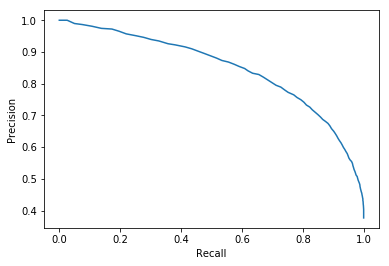

In [132]:
logistic_summary = ols_model.summary

# Precision-Recall Curve
import matplotlib.pyplot as plt
import pandas as pd

pr = logistic_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### 3b) Lasso Regresion

In [97]:
# create lasso model
lasso_cv = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=1)
# parameter grid
pars111 = ParamGridBuilder().addGrid(lasso_cv.regParam,[0.1,1,5,10]).build()
# regression evaluator (CHANGE EVALUATOR?)
#reg_eval = RegressionEvaluator().setMetricName('rmse').setLabelCol('label_idx')
class_eval =  BinaryClassificationEvaluator().setLabelCol('label_idx').setMetricName('areaUnderPR')
# create cross validator
cv_lasso_1 = CrossValidator().setEstimator(lasso_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars111)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [98]:
# run cross validation
cv_lasso_model_1 = cv_lasso_1.fit(train)
# get best model
best_lasso_1 = cv_lasso_model_1.bestModel
# output best parameter
best_lasso_1._java_obj.getRegParam()

0.1

Ran cross validation a second time: 

In [103]:
# parameter grid
pars112 = ParamGridBuilder().addGrid(lasso_cv.regParam,[0.0001,0.001,0.1,0.5]).build()
# create cross validator
cv_lasso_2 = CrossValidator().setEstimator(lasso_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars112)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [104]:
# run cross validation asecond time
cv_lasso_model_2 = cv_lasso_2.fit(train)
# get best model
best_lasso_2 = cv_lasso_model_2.bestModel
# output best parameter
best_lasso_2._java_obj.getRegParam()

0.001

The final lasso regression model will use `regParam=0.001`.

In [105]:
# create the final model
lasso = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=1, regParam=0.001)
# train the model
lasso_model = lasso.fit(train)
# obtain predictions for test
test_lasso = lasso_model.transform(test)

In [106]:
# output coefficients
print("Lasso intercept: ", lasso_model.intercept)
#print("Lasso coefficients: ", lasso_model.coefficients) # long output
# there are a few zeros

Lasso intercept:  0.6019121645111131


In [108]:
# create confusion matrix
confusion_matrix_lasso = test_lasso.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_lasso.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,469,1124
1,0.0,2327,452


Out of 4,372 observations it misclassified 921. This means it had 78.9% accuracy.

In [110]:
# test error
test_error_lasso = class_eval.evaluate(test_lasso)
print("area under PR on test data for lasso: ", test_error_lasso)

area under PR on test data for lasso:  0.7920453750738384


Visualization of area under PR:

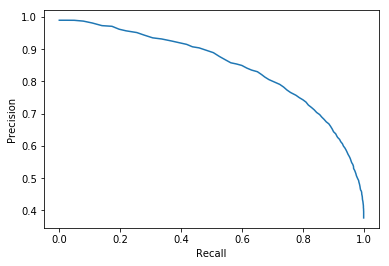

In [135]:
logistic_summary_lasso = lasso_model.summary

# Precision-Recall Curve
pr2 = logistic_summary_lasso.pr.toPandas()
plt.plot(pr2['recall'],pr2['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### 3c) Ridge Regression

In [111]:
# create ridge model
ridge_cv = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=0)
# parameter grid
pars121 = ParamGridBuilder().addGrid(ridge_cv.regParam,[0.1,1,5,10]).build()
# create cross validator
cv_ridge_1 = CrossValidator().setEstimator(ridge_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars121)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [112]:
# run cross validation
cv_ridge_model_1 = cv_ridge_1.fit(train)
# get best model
best_ridge_1 = cv_ridge_model_1.bestModel
# output best parameter
best_ridge_1._java_obj.getRegParam()

0.1

Run cross validation a second time:

In [117]:
# parameter grid
pars122 = ParamGridBuilder().addGrid(ridge_cv.regParam,[0.001,0.01,0.1,0.5]).build()
# create cross validator
cv_ridge_2 = CrossValidator().setEstimator(ridge_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars122)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [118]:
# run cross validation a second time
cv_ridge_model_2 = cv_ridge_2.fit(train)
# get best model
best_ridge_2 = cv_ridge_model_2.bestModel
# output best parameter
best_ridge_2._java_obj.getRegParam()

0.1

The final ridge regression model will use `regParam=0.1`.

In [120]:
# create the final model
ridge = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=0, regParam=0.1)
# train the model
ridge_model = ridge.fit(train)
# obtain predictions for test
test_ridge = ridge_model.transform(test)

In [122]:
# output coefficients
print("Ridge intercept: ", ridge_model.intercept)
#print("Ridge coefficients: ", ridge_model.coefficients) # long

Ridge intercept:  0.16271332697531116


In [123]:
# create confusion matrix
confusion_matrix_ridge = test_ridge.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_ridge.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,590,1003
1,0.0,2479,300


Out of 4,372 observations it misclassified 890. This means it had 79.6% accuracy.

In [125]:
# test error
test_error_ridge = class_eval.evaluate(test_ridge)
print("area under PR on test data for ridge: ", test_error_ridge)

area under PR on test data for ridge:  0.7936207689440483


Visualization of area under PR:

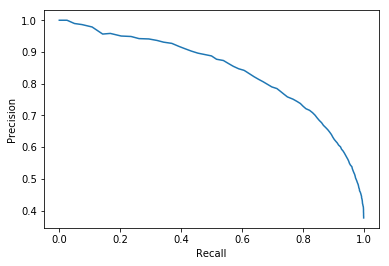

In [136]:
logistic_summary_ridge = ridge_model.summary

# Precision-Recall Curve
pr3 = logistic_summary_ridge.pr.toPandas()
plt.plot(pr3['recall'],pr3['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### We can see that the `ridge regression model` performs slightly better than the lasso and OLS models.